# Closed XXZ Chain Bethe Ansatz Eigenstates on a Quantum Computer
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$

In [1]:
# qiskit 0.29.0

from qiskit import *
from math import pi, acos, sqrt, comb

from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit import Parameter


First, we start by defining a function that runs the usual simulator and gives the simulated results, to test what we should get

In [2]:
def test_circ(circ):
    from qiskit import Aer

    simulator = Aer.get_backend('qasm_simulator')

    # We've set the number of shots (repeats) of the circuit
    # to be 1024, which is the default value
    circ.measure(q,c)
    job_sim = execute(circ, backend=simulator, shots=10240)

    # Grab the results from the job
    result_sim = job_sim.result()

    counts_sim = result_sim.get_counts(circ)
    print(counts_sim)

    # Plot a histogram of the results
    from qiskit.visualization import plot_histogram
    return plot_histogram(counts_sim)

## Step 1: Generating the dicke states $\ket{D_{L,M}}$, by Bärtschi and Eidenbenz (arXiv:1904.07358, 2019)


### Ch 2.2) Explicit Construction of $ SCS_{n k}$

We will try to construct the algorithm by creating circuits for each piece of the puzzles. 

#### Ch 2.2.1) Explicit Construction of the 2-qubit gate (i) of  $ SCS_{n,k}$ 

Initially, we try to replicate the simple 2-qubit component of the $SCS_{n,k}$ gate (i) on page 6

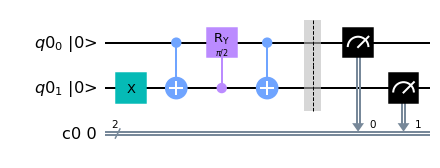

In [3]:
ancilla_multiplier = 1
n = 2*ancilla_multiplier

# create n quantum registers, one for each qubit
q=QuantumRegister(n)

# create n corresponding classical registers (needed for storing measurement results)
c=ClassicalRegister(n)

# create a quantum circuit with these registers.
# circuit type: 2-qubit gate (i)
scs2 = QuantumCircuit(q,c)

last = n-1
first = 0

#input gates(00: both commented; 1/sqrt(2) (01 + 10), comment either; 11, comment none)
#scs2.x(q[last-1])
scs2.x(q[last])

# (i) gate
scs2.cx(q[last-1], q[last])
scs2.cry(2*acos(sqrt(1/n)),q[last], q[last-1])
scs2.cx(q[last-1], q[last])

# measurement gates
scs2.barrier()
scs2.measure(q,c)

scs2.draw(output='mpl', initial_state=True)

#test_circ(scs2)

#### Ch 2.2.2) Explicit Construction of  the 3-qubit gate (ii) of $ SCS_{n k}$ 

Then, we construct the 3-qubit component of the $SCS_{n,k}$ gate (ii) on page 6

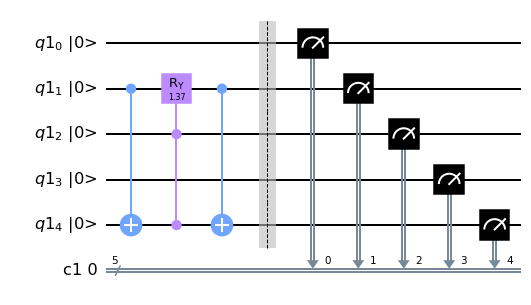

In [4]:
ancilla_multiplier = 1
n = 5*ancilla_multiplier

l = 3

# create 3 quantum registers, one for each qubit
q=QuantumRegister(n)

# create 3 corresponding classical registers (needed for storing measurement results)
c=ClassicalRegister(n)

# create a quantum circuit with these registers.
# circuit type: 2-qubit gate (i)
scs2 = QuantumCircuit(q,c)

last = n-1
first = 0

#input gates(00: both commented; 1/sqrt(2) (01 + 10), comment either; 11, comment none)
#scs2.x(q[last-1])
#scs2.x(q[last])

# (ii) gate
scs2.cx(q[last-l], q[last])

a = 2*acos(sqrt(l/n)) # Parameter('a') # You can replace a with your choice of angle here
CCRY=RYGate(a).control(2)
scs2.append(CCRY,[last, last-l+1,last-l])


scs2.cx(q[last-l], q[last])

# measurement gates
scs2.barrier()
scs2.measure(q,c)

scs2.draw(output='mpl', initial_state=True)

#test_circ(scs2)

#### Ch 2.2.1) Explicit Construction of  the $ U_{n k}$ on n qubits to obtain the Dicke state $\ket{D_{L,M}}$

should have 6 states


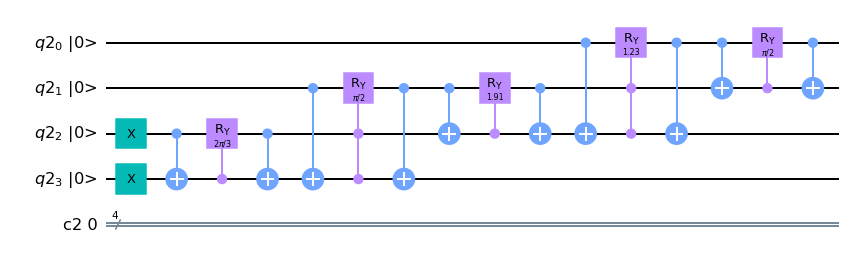

In [5]:
# creating equal-weight superposition of all n-qubit states with 
# Hamming Weight k (i.e. all strings of length n with exactly k 1s over a binary
# alphabet

# or in physics lingo

# creating equal-weight superpositions of M down spins, permuted over a length L spin chain

# should have L choose M distinct states


# how many ancillas you want
ancilla = 0
# how many main qubits you want
main = 4

L = main + ancilla


# how many down spins you want
M = 2

print("should have "+ str(comb(L, M)) + " states")

# create L quantum registers, one for each spin on the chain
q = QuantumRegister(L)

# create L corresponding classical registers (for measurement )
c = ClassicalRegister(L)

# create a quantum circuit with these registers.
# circuit type: Dicke state generator
dicke = QuantumCircuit(q,c)

last = L-1
first = 0

# initializing the |1> qubits:

for i in range(first, M):
    dicke.x(q[last-i])

for i in range(first, last):
    # (i) gate
    dicke.cx(q[last-1-i], q[last-i])
    dicke.cry(2*acos(sqrt(1/(L-i))),q[last-i], q[last-1-i])
    dicke.cx(q[last-1-i], q[last-i])
    if L-i == M:
        # decrease M by 1, if SCS_{M,M} would be reached next
        M = M - 1
    #(ii) gate(s)
    for j in range(0,M-1):
        
        dicke.cx(q[(last-1-i)-1-j], q[last-i])
        ## Constructing the double-controlled Ry gate
        a = 2*acos(sqrt((j+2)/(L-i))) # Parameter('a') # You can replace a with your choice of angle here
        CCRY=RYGate(a).control(2)
        dicke.append(CCRY,[last-i, last-i-1-j,(last-1-i)-1-j])
        
        dicke.cx(q[(last-1-i)-1-j], q[last-i])
        
#    dicke.barrier()

    
# measurement gates
#dicke.measure(q,c)

dicke.draw(output='mpl', initial_state=True)

{'1010': 1681, '1001': 1704, '1100': 1703, '0011': 1733, '0101': 1685, '0110': 1734}


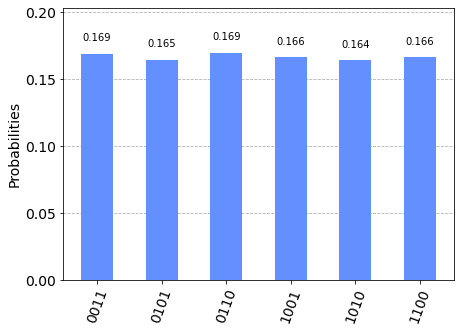

In [6]:
test_circ(dicke)

Exactly like the Eidenbenz paper. 

## Step 2: Constructing the permutation ancillas $\left(\frac{1}{\sqrt{M !}} \sum_{P} A_{P} \otimes_{j=M}^{1}|P j\rangle_{p}\right)$

In [7]:
def ASWAP(circuit, k, target1, target2):
    circuit.cx(q[target2],q[target1])
    circuit.rz(-pi,q[target2])
    circuit.ry(-2.53,q[target2])
    circuit.cx(q[target1],q[target2])
    circuit.ry(2.53,q[target2])
    circuit.rz(pi,q[target2])
    circuit.cx(q[target2],q[target1])

First, construct the circuit on page 5 of 2103.13388.pdf to understand the algorithm 

In [8]:
M = 3

# create 3 quantum registers, one for each qubit
q=QuantumRegister(M**2)

# create 3 corresponding classical registers (needed for storing measurement results)
c=ClassicalRegister(M**2)

# create a quantum circuit with these registers
chain = QuantumCircuit(q,c)

# NOT gates on q[0] and q[1]
chain.x(q[0])
chain.x(q[4])


# double-controlled-NOT (Toffoli) gate; controls={q[0],q[1]};  target=q[2]
# toffoli.ccx(q[0], q[1], q[2])

# Construct ASWAP gates

# ASWAP k=0
## cNOT (controlled-NOT) gate; control=q[0];  target=q[1]
chain.cx(q[4],q[1])


## R_z qubit rotation gate; target=q[4], angle = -pi
chain.rz(-pi,q[4])


## R_y qubit rotation gate; target=q[4], angle = -3*pi/4
chain.ry(-3*pi/4,q[4])



chain.cx(q[1],q[4])


## R_y qubit rotation gate; target=q[4], angle = -3*pi/4
chain.ry(3*pi/4,q[4])

## R_z qubit rotation gate; target=q[4], angle = -pi
chain.rz(pi,q[4])



## cNOT (controlled-NOT) gate; control=q[0];  target=q[1]
chain.cx(q[4],q[1])


# cSWAP (controlled-SWAP gate); control = q[1], target=(q[0], q[3])
chain.cswap(q[1],q[0],q[3])

#chain.cp(pi,q[0], q[1])
#chain.barrier()



chain.x(q[8])

#ASWAP(chain, 0, 5, 8)
chain.cx(q[8],q[5])
chain.rz(-pi,q[8])
chain.ry(-2.53,q[8])
chain.cx(q[5],q[8])
chain.ry(2.53,q[8])
chain.rz(pi,q[8])
chain.cx(q[8],q[5])


chain.cswap(q[5],q[3],q[6])
chain.cswap(q[5],q[4],q[7])
# Construct ASWAP gates

## cNOT (controlled-NOT) gate; control=q[0];  target=q[1]
chain.cx(q[5],q[2])

## R_z qubit rotation gate; target=q[4], angle = -pi
chain.rz(-pi,q[5])

## R_y qubit rotation gate; target=q[4], angle = -3*pi/4
chain.ry(-3*pi/4,q[5])

chain.cx(q[2],q[5])

## R_y qubit rotation gate; target=q[4], angle = -3*pi/4
chain.ry(3*pi/4,q[5])

## R_z qubit rotation gate; target=q[4], angle = -pi
chain.rz(pi,q[5])

## cNOT (controlled-NOT) gate; control=q[0];  target=q[1]
chain.cx(q[5],q[2])


# cSWAPs (controlled SWAP)
chain.cswap(q[2],q[0],q[3])
chain.cswap(q[2],q[1],q[4])

chain.barrier()
#measurement gates
#chain.measure(q, c)

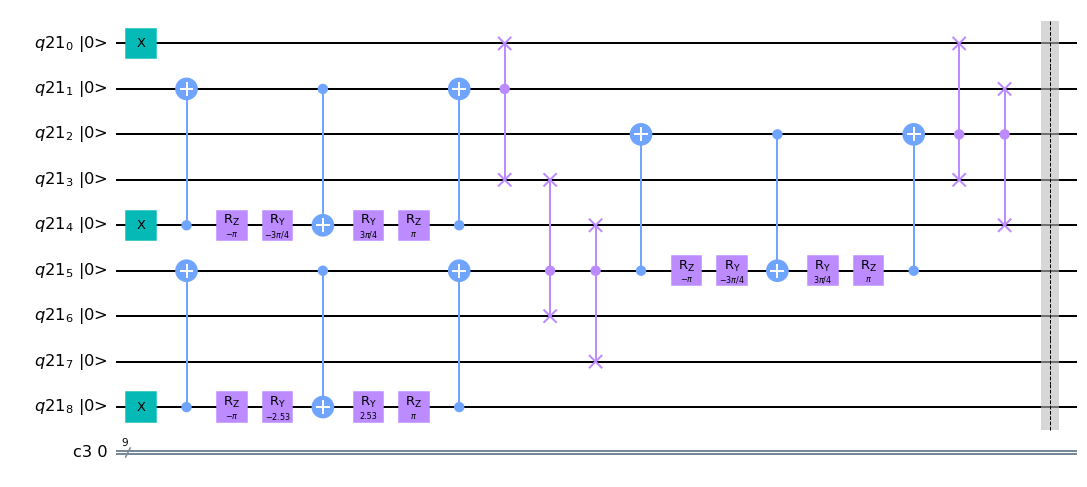

In [9]:
chain.draw(output='mpl', initial_state=True)

{'001010100': 1711, '010001100': 1740, '001100010': 1678, '100010001': 1611, '100001010': 1749, '010100001': 1751}


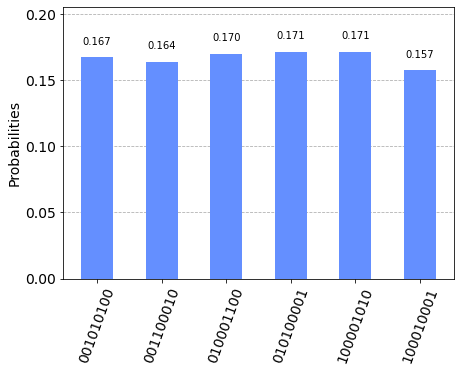

In [10]:
test_circ(chain)

### Executing the circuit on the local qasm simulator

In [11]:
from qiskit import Aer

simulator = Aer.get_backend('qasm_simulator')

In [12]:
# We've set the number of shots (repeats) of the circuit
# to be 1024, which is the default value
chain.measure(q,c)
job_sim = execute(chain, backend=simulator, shots=10240)

In [13]:
# Grab the results from the job
result_sim = job_sim.result()

In [14]:
counts_sim = result_sim.get_counts(chain)
print(counts_sim)

{'100010001': 1651, '010100001': 1711, '100001010': 1733, '001100010': 1631, '001010100': 1751, '010001100': 1763}


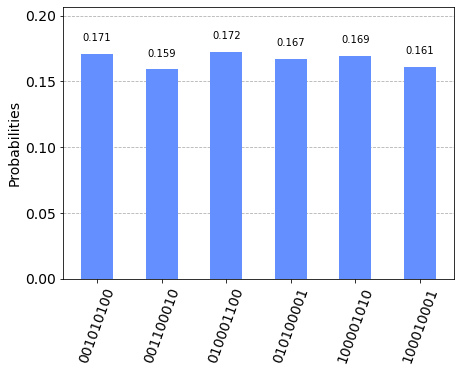

In [15]:
# Plot a histogram of the results
from qiskit.visualization import plot_histogram
plot_histogram(counts_sim)

# For arbitrary M

In [16]:
def index(subregister, qubit):
    return subregister*M+qubit

def angle(k):
    return acos(1/sqrt(k+2))

from qiskit.extensions import UnitaryGate

def ASWAP2(circuit, k, target1, target2):
    gate = [
        [1,      0,              0,        0],
        [0, 1/sqrt(k+2), sqrt((k+1)/(k+2)),0],
        [0, sqrt((k+1)/(k+2)),-1/sqrt(k+2),0],
        [0,     0,              0,        1]]
    circuit.unitary(gate,[target1, target2])
    

In [17]:
M = 4

# create 3 quantum registers, one for each qubit
q=QuantumRegister(M**2)

# create 3 corresponding classical registers (needed for storing measurement results)
c=ClassicalRegister(M**2)

# create a quantum circuit with these registers
chain2 = QuantumCircuit(q,c)

k = 0

# NOT gate on the zeroeth qubit to obtain the 0 subregister.
chain2.x(q[k])

### ITERATION k=0 ###
for k in range(0, M-1):

    # NOT gate on the k+1 qubit of the k+1 subregister
    chain2.x(q[index(k+1,k+1)])

    # partial swap loop

    for i in range(0, k+1):
        # Construct ASWAP gates
        ASWAP2(chain2, k-i, index(k-i,k+1),index(k+1-i,k+1))

        # cSWAPs (controlled-SWAP gate); control = q[1], target=(q[0], q[3])
        # syntax: chain.cswap(q[1],q[0],q[3])

        # Iterate from: control at subregister k, qubit k+1 ---> control = q[index(k,k+1)]
        #                                             targets: (q[index(k,l)], q[index(k+1,l)]) with l =0 to l = k-1

        for l in range(0, k+1):
            chain2.cswap(q[index(k-i,k+1)], q[index(k-i,l)], q[index(k+1-i,l)])
            #chain2.cp(bethePhase,q[index(k-i,l)], q[index(k-i,k+1)])

#chain2.barrier()

# measurement gates
#chain2.measure(q, c)

In [18]:
#chain2.basis = chain2.decompose()

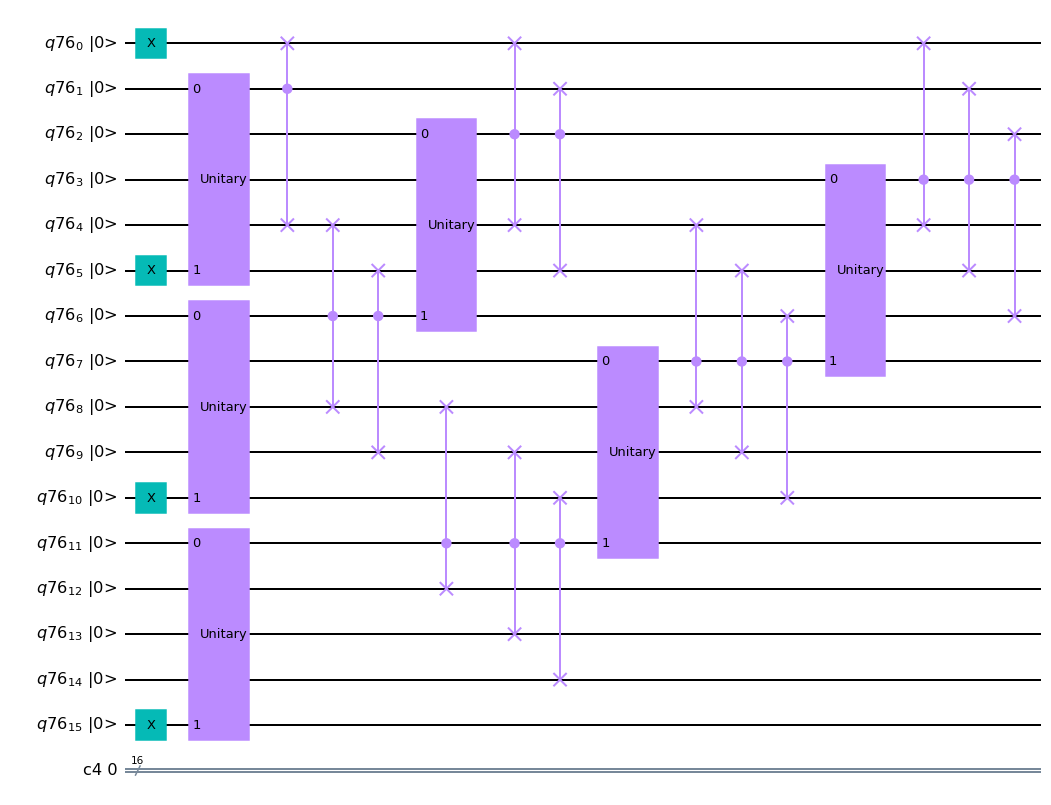

In [19]:
chain2.draw(output='mpl', initial_state=True)

{'0001001001001000': 452, '0001001010000100': 410, '0100100000010010': 433, '0100001010000001': 443, '1000010000100001': 415, '1000000101000010': 430, '0010000101001000': 417, '1000001001000001': 402, '0100000110000010': 422, '0001100000100100': 426, '0100001000011000': 422, '1000001000010100': 435, '0001010000101000': 439, '1000000100100100': 401, '0010010000011000': 444, '0010010010000001': 435, '0100100000100001': 442, '0010000110000100': 424, '0010100001000001': 421, '0010100000010100': 408, '1000010000010010': 447, '0001100001000010': 410, '0001010010000010': 441, '0100000100101000': 421}


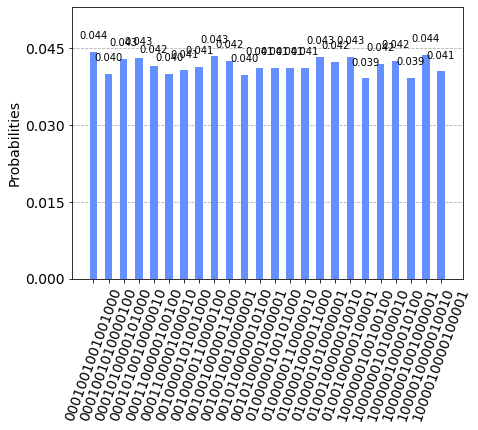

In [20]:
test_circ(chain2)

In [21]:
from qiskit import Aer

simulator = Aer.get_backend('qasm_simulator')

In [22]:
# We've set the number of shots (repeats) of the circuit
# to be 1024, which is the default value
#measurement gates
chain2.measure(q, c)
job_sim = execute(chain2, backend=simulator, shots=1024000)

In [23]:
# Grab the results from the job
result_sim = job_sim.result()

In [24]:
counts_sim = result_sim.get_counts(chain2)
print(counts_sim)

{'0100000100101000': 42751, '0010100000010100': 42891, '0010100001000001': 42645, '0100000110000010': 42611, '0010010010000001': 42606, '0001010010000010': 42964, '0001001010000100': 42719, '0100100000010010': 42380, '1000010000010010': 42666, '0010000101001000': 42496, '1000000101000010': 42678, '1000001001000001': 42809, '1000001000010100': 42780, '0001100000100100': 42654, '0100001000011000': 42697, '0100100000100001': 42462, '0001010000101000': 42654, '1000000100100100': 42690, '1000010000100001': 42513, '0100001010000001': 42593, '0001001001001000': 42760, '0010000110000100': 42588, '0010010000011000': 42634, '0001100001000010': 42759}


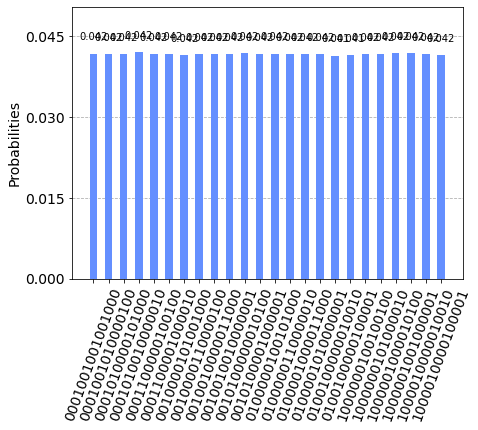

In [25]:
# Plot a histogram of the results
from qiskit.visualization import plot_histogram
plot_histogram(counts_sim)

## Step 3: The faucet method

First we need to be able to combine the dicke and the permutatuion circuits to implement the faucet method. 

In [42]:
def index(subregister, qubit):
    return subregister*M+qubit

def angle(k):
    return acos(1/sqrt(k+2))

from qiskit.extensions import UnitaryGate

def ASWAP2(circuit, k, target1, target2):
    gate = [
        [1,      0,              0,        0],
        [0, 1/sqrt(k+2), sqrt((k+1)/(k+2)),0],
        [0, sqrt((k+1)/(k+2)),-1/sqrt(k+2),0],
        [0,     0,              0,        1]]
    circuit.unitary(gate,[target1,target2])
    

should have 6 states
0 2


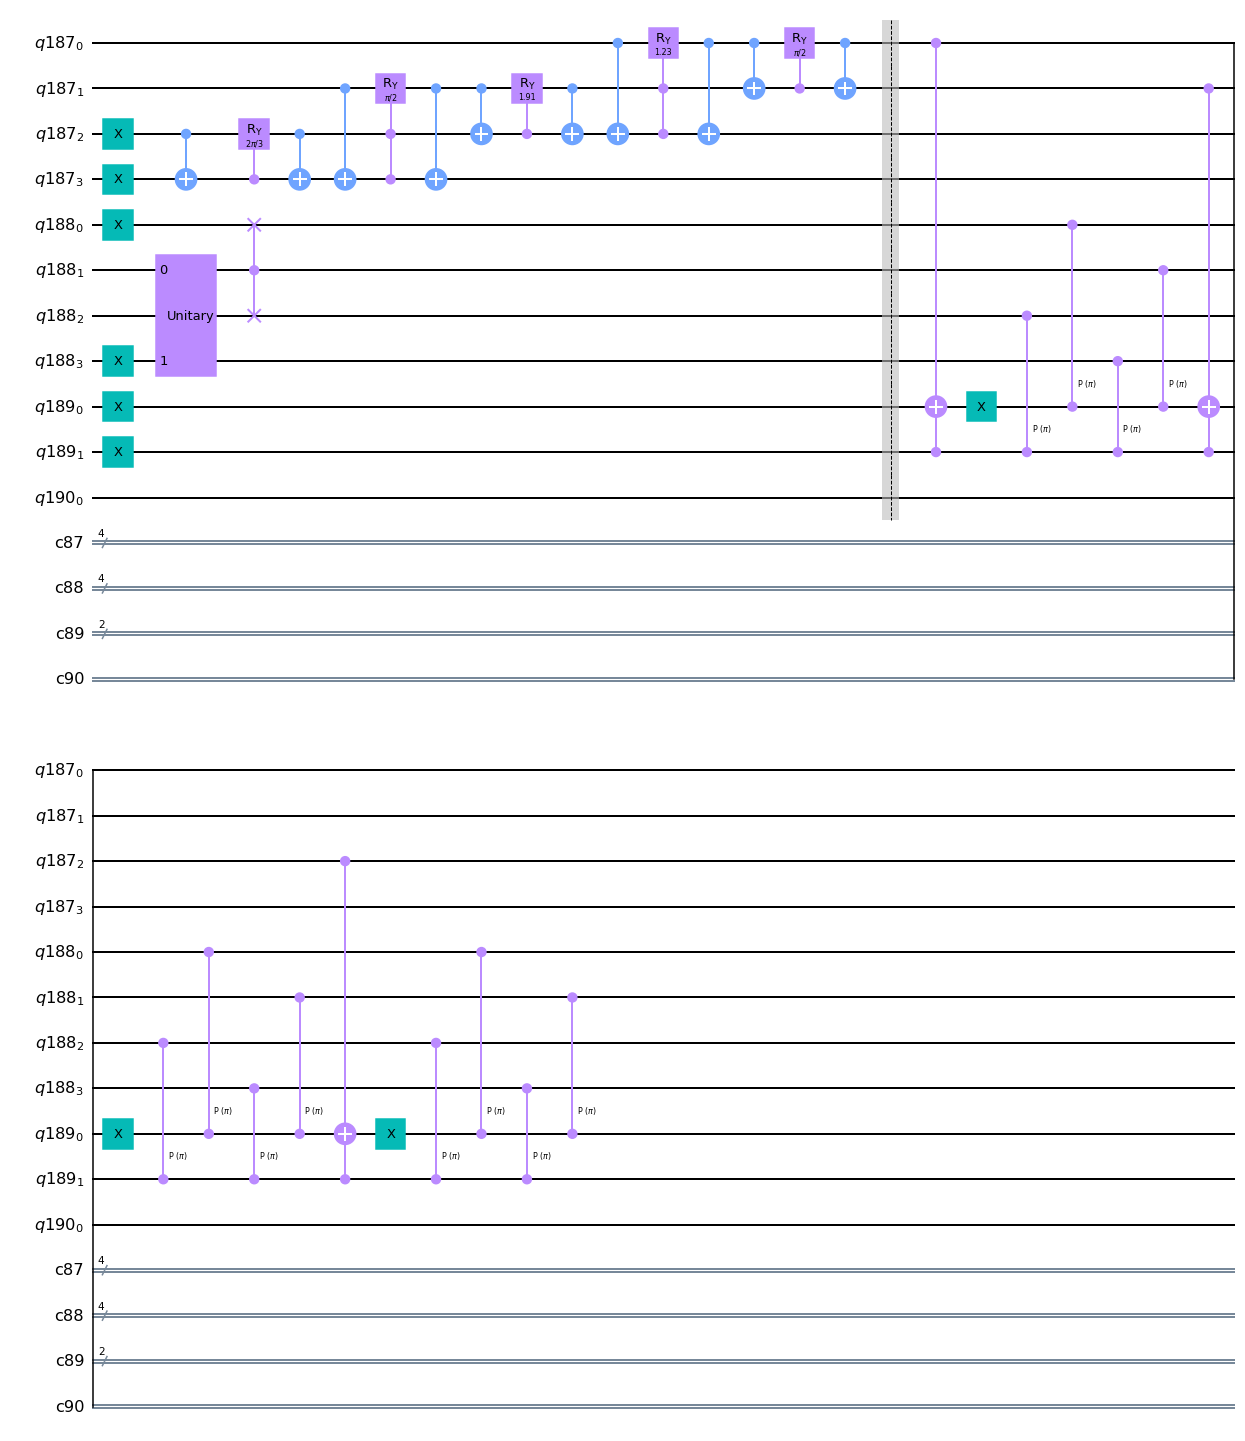

In [58]:
# creating equal-weight superposition of all n-qubit states with 
# Hamming Weight k (i.e. all strings of length n with exactly k 1s over a binary
# alphabet

# or in physics language

# creating equal-weight superpositions of M down spins, permuted over a length L spin chain

# should have L choose M distinct states


# how many ancillas you want
ancilla = 0
# how many main qubits you want
main = 4

L = main + ancilla


# how many down spins you want
init_M = 2

M = init_M

print("should have "+ str(comb(L, M)) + " states")

# create L quantum registers, one for each spin on the chain 
                                #plus M^2 for the permutation ancillas
                                #plus M faucet ancillas 
qSys = QuantumRegister(L)
qPerm = QuantumRegister(M**2)
qFaucet = QuantumRegister(M)
qWork = QuantumRegister(1)

# create corresponding classical registers (for measurement )
cSys = ClassicalRegister(L)
cPerm = ClassicalRegister(M**2)
cFaucet = ClassicalRegister(M)
cWork = ClassicalRegister(1)

# create a quantum circuit with these registers.
# circuit type: Bethe Eigenstate generator
bethe = QuantumCircuit(qSys, qPerm, qFaucet, qWork, cSys, cPerm, cFaucet, cWork)


#### DICKE STATES ####

first = 0
last = L-1


# initializing the 1 qubits:

for i in range(first, M):
    bethe.x(qSys[last-i])

for i in range(first, last):
    # (i) gate
    bethe.cx(qSys[last-1-i], qSys[last-i])
    bethe.cry(2*acos(sqrt(1/(L-i))),qSys[last-i], qSys[last-1-i])
    bethe.cx(qSys[last-1-i], qSys[last-i])
    if L-i == M:
        # decrease M by 1, if SCS_{M,M} would be reached next
        M = M - 1
    #(ii) gate(s)
    for j in range(0,M-1):
        
        bethe.cx(qSys[(last-1-i)-1-j], qSys[last-i])
        ## Constructing the double-controlled Ry gate
        a = 2*acos(sqrt((j+2)/(L-i))) # Parameter('a') # You can replace a with your choice of angle here
        CCRY=RYGate(a).control(2)
        bethe.append(CCRY,[last-i, last-i-1-j,(last-1-i)-1-j])
        
        bethe.cx(qSys[(last-1-i)-1-j], qSys[last-i])
        

### THE PERMUTATION ANCILLAS ####


M = init_M

k = 0

#NOT gate on the zeroeth qubit to obtain the 0 subregister.
bethe.x(qPerm[index(0,k)])


for k in range(0, M-1):

    # NOT gate on the k+1 qubit of the k+1 subregister
    bethe.x(qPerm[index(k+1,k+1)])

    # partial swap loop

    for i in range(0, k+1):
        # Construct ASWAP gates
        ASWAP2(bethe, k-i, index(k-i,k+1)+L,index(k+1-i,k+1)+L)

        # cSWAPs (controlled-SWAP gate); control = q[1], target=(q[0], q[3])
        # syntax: chain.cswap(q[1],q[0],q[3])

        # Iterate from: control at subregister k, qubit k+1 ---> control = q[index(k,k+1)]
        #                                         targets: (q[index(k,l)], q[index(k+1,l)]) with l =0 to l = k-1

        for l in range(0, k+1):
            bethe.cswap(qPerm[index(k-i,k+1)], qPerm[index(k-i,l)], qPerm[index(k+1-i,l)])
            #bethe.cp(bethePhase,q[index(k-i,l)], q[index(k-i,k+1)])
            #plug in the bethe roots (real) here
bethe.draw()

#### FAUCET ANCILLAS ####

dickeFirst = first
dickeLast = last

first = 0
last = first+M

# initialize the faucets to |1>

for i in range(first, last):
    bethe.x(qFaucet[i])
bethe.barrier()

for i in range(dickeFirst, dickeLast):
    for j in range(first, last):
        if j > first:
            bethe.x(qFaucet[first])
        if ((j+1)!=M):
            bethe.ccx(qSys[i], qFaucet[(j+1)%M], qFaucet[j%M])
            
    for j in range(first, last):
        for l in range(index(j,0),index(j,M)):
            bethe.cp(pi, qPerm[l], qFaucet[j])
print(first, last)

bethe.draw('mpl')
# ### REVERSING THE PERMUTATION ANCILLAS ###

# for k in range(0, M-1):

#     # partial swap loop

#     for i in range(0, k+1):
#         # cSWAPs (controlled-SWAP gate); control = q[1], target=(q[0], q[3])
#         # syntax: chain.cswap(q[1],q[0],q[3])

#         # Iterate from: control at subregister k, qubit k+1 ---> control = q[index(k,k+1)]
#         #                          targets: (q[index(k,l)], q[index(k+1,l)]) with l =0 to l = k-1

#         for l in range(0, k+1):
#             bethe.cswap(q[index(k-i,k+1)], q[index(k-i,l)], q[index(k+1-i,l)])
#             #bethe.cp(bethePhase,q[index(k-i,l)], q[index(k-i,k+1)])
#             #plug in the bethe roots (real) here
            
#         # Construct ASWAP gates
#         ASWAP2(bethe, k-i, index(k-i,k+1),index(k+1-i,k+1))
            
    
#     # NOT gate on the k+1 qubit of the k+1 subregister
#     bethe.x(q[index(k+1,k+1)])


# # measurement gates
# bethe.measure(q, c)
# bethe.draw('mpl')